<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S4_FaceRecognition/EVA4_S4_preprocessing_face_alignment_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import dlib
import cv2
import numpy as np
import glob
import os
import shutil
import pandas as pd
import random
#from renderFace import renderFace
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## 1a. Loading face alignment code from Github 

In [3]:
# Cleaning previous run directories
!rm -rf Data
!rm -rf model
!rm -rf shape*.*
!rm -rf Data_Processed
!rm -rf lfw_funneled

# Creating directories required for processing
!mkdir Data
!mkdir model
!mkdir Data_Processed

In [4]:
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv /content/Phase2/Modules/faceblendcommon.py /content/
!rm -rf Phase2

# Downloading DLIB model used for landmark prediction
!wget -q http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_5_face_landmarks.dat.bz2
!mv shape_predictor_5_face_landmarks.dat /content/model 

# 2. Loading the dataset curated for 10 politician/celebrities and LFW dataset

In [5]:
# Own dataset
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S4/Data_v1.zip
!unzip -q Data_v1.zip -d /content

# Creating folder structure and cleaning up unnecssary files
!mv /content/Data_v1/* /content/Data/
!rm -rf /content/__MACOSX
!rm -rf /content/Data_v1
!find /content/Data -name '.DS_Store' -type f -delete

In [16]:
# Keeping only celebreties with >=20 images
DATA_PATH = "/content/Data/"
df_custom_data = pd.DataFrame() 
index = 0
for filecomppath in glob.iglob(DATA_PATH + "*"):
  #print(filecomppath)
  label = filecomppath.split("/")[-1]
  image_list = [name for name in os.listdir(filecomppath)]
  image_list_str = ",".join(image_list)
  image_list_train_str = ",".join(random.sample(image_list,int(0.7*len(image_list))))

  temp_data = pd.DataFrame({"Label": label,
                            "Count":len(image_list),
                            "FileList":image_list_str,
                            "FileList_Train":image_list_train_str}, index=[index])
  df_custom_data = pd.concat([df_custom_data,temp_data])
  index+=1

In [19]:
df_custom_data.head()

,Label,Count,FileList,FileList_Train
0,MalalaYousafzai,20,"img6.jpg,img20.jpg,img17.jpeg,img10.jpg,img11....","img19.jpg,img1.jpg,img9.jpg,img17.jpeg,img6.jp..."
1,NarendraModi,20,"img6.jpg,img20.jpg,img10.jpg,img11.jpg,img3.jp...","img16.jpg,img4.jpg,img7.jpg,img19.jpg,img6.jpg..."
2,SachinTendulkar,22,"img6.jpg,img20.jpg,img21.jpg,img10.jpg,img11.j...","img1.jpg,img4.jpg,img14.jpg,img15.jpg,img21.jp..."
3,PriyankaChopra,20,"img6.jpg,img20.jpg,img10.jpg,img11.jpg,img3.jp...","img17.jpg,img18.jpg,img10.jpg,img19.jpg,img3.j..."
4,AishwaryaRai,20,"img6.jpg,img20.jpg,img10.jpg,img11.jpg,img3.jp...","img19.jpg,img16.jpg,img15.jpg,img7.jpg,img1.jp..."


In [22]:
# Downloading LFW 
!wget -q http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
!tar -xzf lfw-funneled.tgz

# Delete txt file
!find /content/lfw_funneled -name '*.txt' -type f -delete

In [23]:
# Keeping only celebreties with >=20 images
DATA_PATH = "/content/lfw_funneled/"
df_lfw = pd.DataFrame() 
index = 0
for filecomppath in glob.iglob(DATA_PATH + "*"):
  #print(filecomppath)
  label = filecomppath.split("/")[-1]
  image_list = [name for name in os.listdir(filecomppath)]
  image_list_str = ",".join(image_list)
  image_list_train_str = ",".join(random.sample(image_list,int(0.7*len(image_list))))

  temp_data = pd.DataFrame({"Label": label,
                            "Count":len(image_list),
                            "FileList":image_list_str,
                            "FileList_Train":image_list_train_str}, index=[index])
  
  df_lfw = pd.concat([df_lfw,temp_data])
  index+=1
  if len(image_list)<20:
    try:
        shutil.rmtree(filecomppath)
    except OSError as e:
        print("Error: %s : %s" % (filecomppath, e.strerror))

In [25]:
df_lfw_subset = df_lfw[df_lfw["Count"]>=20].copy()

In [26]:
df_lfw_subset.shape

(62, 4)

# 3. Sample processing of our custom data

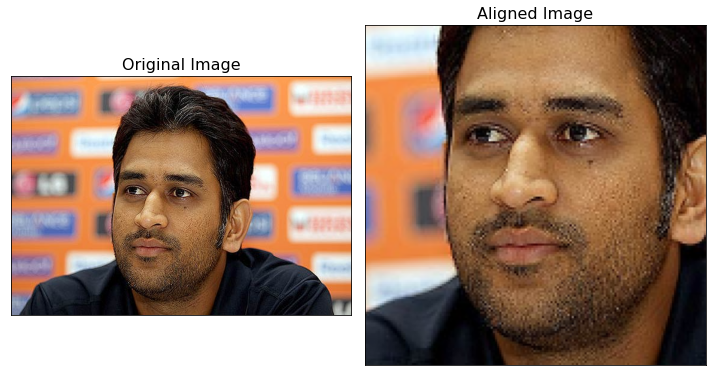

In [27]:
import faceblendcommon as fbc

MODEL_PATH = "/content/model/"
# Landmark model location
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

DATA_PATH = "/content/Data/"
# Read image
#im = cv2.imread(DATA_PATH + "images/face2.jpg")
im = cv2.imread(DATA_PATH + "MahendraSinghDhoni/img7.jpg")

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(im[:,:,::-1])
ax.set_title("Original Image",fontsize=16)

# Detect landmarks
points = fbc.getLandmarks(faceDetector, landmarkDetector, im)

points = np.array(points)

# Convert image to floating point in the range 0 to 1
im = np.float32(im)/255.0

# Dimension of output image
h = 160
w = 160

# Normalize image to output co-orindates
imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)

imNorm = np.uint8(imNorm*255)

# Display the results
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(imNorm[:,:,::-1])
ax.set_title("Aligned Image",fontsize=16)
#plt.axis("off")
plt.tight_layout()
plt.show()

# 4. Face Alignment Pipeline and processing of complete custom data

In [54]:
DATA_PATH = "/content/Data/"
for filecomppath in glob.glob(DATA_PATH+'**/*.jpg',recursive=True):
  src_loc = os.path.dirname(filecomppath)
  filename = os.path.basename(filecomppath)
  
  #print(filecomppath)
  train_file_list_temp = df_custom_data.loc[df_custom_data['Label']==src_loc.split("/")[-1],
                                            'FileList_Train'].values[0]
  dst_loc_str = "Data_Processed/" + "train" if filename in train_file_list_temp else "Data_Processed/" + "val" 

  dst_loc = src_loc.replace("Data",dst_loc_str)

  if not os.path.isdir(dst_loc):
    os.makedirs(dst_loc, exist_ok=True)

  # Reading image
  im = cv2.imread(filecomppath)

  # Detect landmarks
  points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
  points = np.array(points)

  if(len(points)>0):
    # Convert image to floating point in the range 0 to 1
    im = np.float32(im)/255.0

    # Dimension of output image
    h = 160
    w = 160

    # Normalize image to output co-orindates
    imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)

    imNorm = np.uint8(imNorm*255)
    #print(dst_loc+"/"+filename)
    cv2.imwrite(dst_loc+"/"+filename, imNorm)
  else:
    print(f"Issue with image{filecomppath}")

# 5. Sample processing of LFW subset data

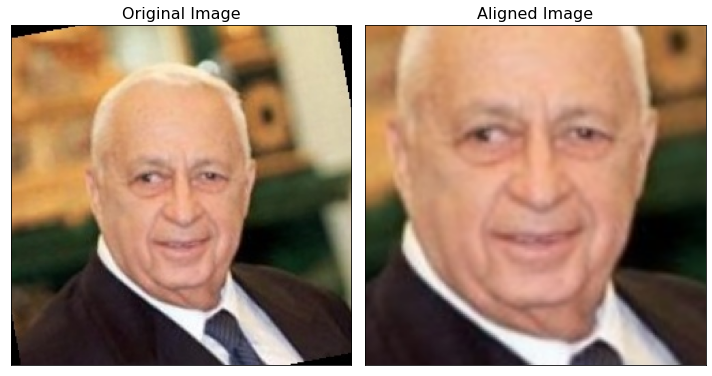

In [55]:
DATA_PATH = "/content/lfw_funneled/"
# Read image
#im = cv2.imread(DATA_PATH + "images/face2.jpg")
im = cv2.imread(DATA_PATH + "Ariel_Sharon/Ariel_Sharon_0001.jpg")

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(im[:,:,::-1])
ax.set_title("Original Image",fontsize=16)

# Detect landmarks
points = fbc.getLandmarks(faceDetector, landmarkDetector, im)

points = np.array(points)

# Convert image to floating point in the range 0 to 1
im = np.float32(im)/255.0

# Dimension of output image
h = 160
w = 160

# Normalize image to output co-orindates
imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)

imNorm = np.uint8(imNorm*255)

# Display the results
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(imNorm[:,:,::-1])
ax.set_title("Aligned Image",fontsize=16)
#plt.axis("off")
plt.tight_layout()
plt.show()

# 6. Face Alignment Pipeline and processing of subset LFW data

In [62]:
DATA_PATH = "/content/lfw_funneled/"
for filecomppath in glob.glob(DATA_PATH+'**/*.jpg',recursive=True):
  src_loc = os.path.dirname(filecomppath)
  filename = os.path.basename(filecomppath)
  
  #print(filecomppath)
  train_file_list_temp = df_lfw_subset.loc[df_lfw_subset['Label']==src_loc.split("/")[-1],
                                            'FileList_Train'].values[0]
  dst_loc_str = "Data_Processed/" + "train" if filename in train_file_list_temp else "Data_Processed/" + "val" 

  dst_loc = src_loc.replace("lfw_funneled",dst_loc_str)

  if not os.path.isdir(dst_loc):
    os.makedirs(dst_loc, exist_ok=True)

  # Reading image
  im = cv2.imread(filecomppath)

  # Detect landmarks
  points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
  points = np.array(points)

  if(len(points)>0):
    # Convert image to floating point in the range 0 to 1
    im = np.float32(im)/255.0

    # Dimension of output image
    h = 160
    w = 160

    # Normalize image to output co-orindates
    imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)

    imNorm = np.uint8(imNorm*255)
    #print(dst_loc+"/"+filename)
    cv2.imwrite(dst_loc+"/"+filename, imNorm)
  else:
    print(f"Issue with image{filecomppath}")

Issue with image/content/lfw_funneled/Jacques_Chirac/Jacques_Chirac_0010.jpg
Issue with image/content/lfw_funneled/Jacques_Chirac/Jacques_Chirac_0006.jpg
Issue with image/content/lfw_funneled/George_W_Bush/George_W_Bush_0268.jpg
Issue with image/content/lfw_funneled/Mahmoud_Abbas/Mahmoud_Abbas_0021.jpg


In [63]:
!zip -r -q Data_v2_Processed.zip Data_Processed